<h1>
<center>CFRM 421/521</center>
</h1>

<h1>
<center>[Lanmin Lin]</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Tuesday, April 15, 2025, 11:59 PM**


* Total marks: 49


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [10 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [184]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [185]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [186]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [187]:
X_raw.shape

(16512, 9)

In [188]:
X_raw[X_raw.isnull().any(axis=1)].shape

(168, 9)

In [189]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.

**Solution:**

In [190]:
null_rows_idx = X_raw.isnull().any(axis=1)
X_raw.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [191]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [192]:
X_raw_num = X_raw.select_dtypes(include=[np.number])

In [193]:
imputer.fit(X_raw_num)

SimpleImputer(strategy='median')

In [194]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [195]:

X_raw_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [196]:
X = imputer.transform(X_raw_num)

In [197]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [198]:
X_raw_tr = pd.DataFrame(X, columns=X_raw_num.columns,
                          index=X_raw_num.index)

In [199]:
X_raw_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**Solution:**

In [200]:
X_raw_cat = X_raw[["ocean_proximity"]]
X_raw_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [201]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
X_raw_cat_encoded = ordinal_encoder.fit_transform(X_raw_cat)

In [202]:

X_raw_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [203]:
df_output_encond = pd.DataFrame(X_raw_cat_encoded,
                          columns=ordinal_encoder.get_feature_names_out(),
                          index=X_raw_cat.index)
df_output_encond

,ocean_proximity
13096,3.0
14973,0.0
3785,1.0
14689,1.0
20507,4.0
...,...
14207,0.0
13105,1.0
19301,4.0
19121,0.0


In [204]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [205]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
X_raw_cat_1hot = cat_encoder.fit_transform(X_raw_cat)
X_raw_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [206]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [207]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [208]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [209]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [210]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [211]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [212]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [213]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [214]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [215]:
df_output_1hot = pd.DataFrame(X_raw_cat_1hot,
                         columns=cat_encoder.get_feature_names_out(),
                         index=X_raw_cat.index)
df_output_1hot

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
14207,1.0,0.0,0.0,0.0,0.0
13105,0.0,1.0,0.0,0.0,0.0
19301,0.0,0.0,0.0,0.0,1.0
19121,1.0,0.0,0.0,0.0,0.0


It is more appropriate to use one-hot encoding. Unlike label encoding, which assigns a unique integer to each category and may inadvertently introduce a false sense of hierarchy or magnitude, one-hot encoding represents each category as a separate binary feature. This prevents machine learning models from misinterpreting the categorical values as ordered or numeric, which can distort predictions in algorithms like linear regression, logistic regression, or neural networks. One-hot encoding also improves model interpretability, as each binary column clearly indicates the presence or absence of a specific category. Additionally, it is compatible with most machine learning algorithms and can be made robust by setting `handle_unknown='ignore'`, allowing the model to gracefully handle unseen categories during inference.

## (c) Feature engineering [2 marks]

Often it may be useful to experiment with transforming and combining features to create new features that may be expected to better predict the target variable. Features that are skewed or heavily tailed can be logged to make them closer to normal. An example of a feature combination is instead of using the number of bedrooms, which may not be meaningful by itself, we should consider the number of bedrooms relative to the number of rooms.

**Task:** Read the subsections "Custom Transformers" and "Transformation Pipelines" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.FunctionTransformer` class take the log of `population`, and to create the ratio `total_bedrooms/total_rooms`. Print these two transformed features.

**Solution:**

In [216]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(X_raw[["population"]])
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [217]:
ratio_transformer = X_raw["total_bedrooms"] / X_raw["total_rooms"]
print(ratio_transformer)

13096    0.335742
14973    0.180153
3785     0.200369
14689    0.203881
20507    0.277371
           ...   
14207    0.266875
13105    0.201019
19301    0.197704
19121    0.230891
19888    0.452436
Length: 16512, dtype: float64


## (d) Feature scaling and transformation [1 mark]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have a similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1, here we focus on the latter.

**Task:** Read the subsection "Feature Scaling and Transformation" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.StandardScaler` class to scale the numerical features using standardization. 

**Solution:**

In [218]:
from sklearn.preprocessing import StandardScaler

X_raw_num = X_raw.drop("ocean_proximity", axis=1)

scaler = StandardScaler()

X_raw_scaled = scaler.fit_transform(X_raw_num)

import pandas as pd
X_raw_scaled_df = pd.DataFrame(X_raw_scaled, columns=X_raw_num.columns, index=X_raw_num.index)

X_raw_scaled_df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.736231,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.585590,0.444376,1.755263,-0.180365


## (e) Transformation pipelines [4 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `ColumnTransformer` and `Pipeline` classes provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then create one pipeline that combines the above steps  in the following way applied to the original "raw" features `X_raw`: part (a) (a median imputer for numerical features), part (c) (create the ratios `total_bedrooms/total_rooms`, `total_rooms/households`, `population/households`; and take the log of `total_bedrooms`, `total_rooms`, `population`, `households`, `median_income`), part (d) (a standard scaler for all numerical features, including the transformed features), part (b) (one-hot encoding for categorical variables). Call your transformed features `X`, and print it.

**Solution:**

In [219]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")
)

# --- ColumnTransformer to combine everything ---
preprocessing = ColumnTransformer([
    ("bedrooms_ratio", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("num", default_num_pipeline, ["housing_median_age"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)), ],
    remainder=default_num_pipeline)


X = preprocessing.fit_transform(X_raw)
print(X)
print("Transformed shape:", X.shape)

[[ 1.84662439 -0.86602737 -0.33020372 ...  0.         -1.42303652
   1.0136059 ]
 [-0.5081207   0.0245495  -0.25361631 ...  0.          0.59639445
  -0.702103  ]
 [-0.20215476 -0.04119332 -0.05104091 ...  0.         -1.2030985
   1.27611874]
 ...
 [-0.24249175 -0.10998748  0.15854151 ...  1.          1.25620853
  -1.42870103]
 [ 0.25977479 -0.36093745 -0.21033248 ...  0.          0.58639727
  -0.73960483]
 [ 3.61270996 -1.32397227  0.04958379 ...  1.         -1.41803793
   0.94797769]]
Transformed shape: (16512, 16)


# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(e) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**Solution:**

In [220]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)




LinearRegression()

In [221]:
# Predict on the first 10 training samples
y_pred_first10 = lin_reg.predict(X[:10])

print("Predicted median house values for first 10 observations:")
print(y_pred_first10)

Predicted median house values for first 10 observations:
[260051.36004114 357897.79846769 125817.08984353 110019.21093156
 298948.54915206 206437.53193813 306787.013961   326902.92850959
 162297.74181859  68786.66157655]


## (b) RMSE and MAE  [2 marks]

We can measure the performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**Solution:**

In [222]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict on the entire training set
y_pred = lin_reg.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate MAE
mae = mean_absolute_error(y, y_pred)

print("In-sample RMSE:", rmse)
print("In-sample MAE:", mae)


In-sample RMSE: 70630.22169174394
In-sample MAE: 53034.28396497742


## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**Solution:**

In [223]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform 10-fold cross-validation (neg_mean_squared_error is used, so we negate and take sqrt)
neg_mse_scores = cross_val_score(lin_reg, X, y, scoring="neg_root_mean_squared_error", cv=10)
rmse_scores = -neg_mse_scores

# Print each RMSE and their mean
print("10-fold RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())


10-fold RMSE scores: [72183.9055149  69449.07233135 68141.82330925 82348.92814938
 70200.08524327 70974.12115166 70512.16910063 73276.85042458
 69387.52951303 71463.70091766]
Mean RMSE: 71793.81856557202
Standard deviation: 3786.165787099044


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [224]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [225]:
dt_reg.predict(X[:10,])

array([458300., 483800., 101700.,  96100., 361800.,  92600., 349300.,
       440900., 160100., 183900.])

The following code does the same for the random forest model.

In [226]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [227]:
rf_reg.predict(X[:10,])

array([226052.57663663, 408572.3162281 , 100944.59292661,  95012.98416211,
       323566.08786234, 135098.37280907, 283371.7148996 , 357336.26089032,
       167697.90412093, 146436.2407077 ])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**Solution:**

In [228]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

dt_rmse_train = np.sqrt(mean_squared_error(y, dt_reg.predict(X)))

dt_cv_scores = cross_val_score(dt_reg, X, y, scoring="neg_mean_squared_error", cv=10)
dt_rmse_cv = np.sqrt(-dt_cv_scores)


rf_rmse_train = np.sqrt(mean_squared_error(y, rf_reg.predict(X)))

rf_cv_scores = cross_val_score(rf_reg, X, y, scoring="neg_mean_squared_error", cv=10)
rf_rmse_cv = np.sqrt(-rf_cv_scores)

# Print comparison
print("In-sample RMSEs:")
print(f"Linear Regression: {rmse:.2f}")
print(f"Decision Tree:     {dt_rmse_train:.2f}")
print(f"Random Forest:     {rf_rmse_train:.2f}")

print("\nOut-of-sample RMSE (CV mean ± std):")
print(f"Linear Regression: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
print(f"Decision Tree:     {dt_rmse_cv.mean():.2f} ± {dt_rmse_cv.std():.2f}")
print(f"Random Forest:     {rf_rmse_cv.mean():.2f} ± {rf_rmse_cv.std():.2f}")


In-sample RMSEs:
Linear Regression: 70630.22
Decision Tree:     0.00
Random Forest:     62145.37

Out-of-sample RMSE (CV mean ± std):
Linear Regression: 71793.82 ± 3786.17
Decision Tree:     69719.50 ± 1497.13
Random Forest:     63714.28 ± 1033.18


Desicison Tree has the best in-sample pertormance.
Random Forest has the best out-of-sample perormance.

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has hyperparameter including `n_estimators` and `max_features`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `max_features` over the values 4, 6, 8, 10 and `n_estimators` over the values 10, 50, 100. Use 3-fold cross-validation with RMSE when searching for the best hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search with 10 iterations, where  `max_features` is a uniform random integer between 2 and 20 and `n_estimators` is a uniform random integer between 10 and 200. `RandomizedSearchCV` must include the argument `random_state=42`.


In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**Solution:**

In [229]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Base random forest model
rf_base = RandomForestRegressor(random_state=42)

# Grid Search
param_grid = {
    "n_estimators": [10, 50, 100],
    "max_features": [4, 6, 8, 10]
}

grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1
)
grid_search.fit(X, y)

# Randomized Search
param_dist = {
    "n_estimators": randint(10, 200),
    "max_features": randint(2, 20)
}

random_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

# Results
from pprint import pprint

print("Best parameters from GridSearchCV:")
pprint(grid_search.best_params_)

print("\nBest parameters from RandomizedSearchCV:")
pprint(random_search.best_params_)

# Calculate best RMSE for GridSearchCV
best_rmse_grid = np.sqrt(-grid_search.best_score_)

# Calculate best RMSE for RandomizedSearchCV
best_rmse_random = np.sqrt(-random_search.best_score_)

print("Best RMSE from GridSearchCV: {:.2f}".format(best_rmse_grid))
print("Best RMSE from RandomizedSearchCV: {:.2f}".format(best_rmse_random))


Best parameters from GridSearchCV:
{'max_features': 6, 'n_estimators': 100}

Best parameters from RandomizedSearchCV:
{'max_features': 7, 'n_estimators': 139}
Best RMSE from GridSearchCV: 49410.23
Best RMSE from RandomizedSearchCV: 49334.13


Based on all of my results, the best hyperparameter values are max_features: 7, n_estimators: 139.

## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**Solution:**

In [230]:
from sklearn.metrics import mean_squared_error
import numpy as np

X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test = preprocessing.transform(X_test_raw)
final_model = random_search.best_estimator_
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test set RMSE:", rmse_test)

Test set RMSE: 48635.19945640085


# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**Solution:**

In [231]:
from sklearn.preprocessing import PolynomialFeatures

polyfeatures = make_pipeline(PolynomialFeatures(degree = 3,include_bias = False), StandardScaler())
X_poly = polyfeatures.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly, y)

LinearRegression()

In [232]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_poly, y)

Ridge(alpha=1, solver='cholesky')

## (b) Learning curves [4 marks]

Obtain learning curves using the function `sklearn.model_selection.learning_curve` to plot the learning curve with 5-fold CV for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither.

**Solution:**

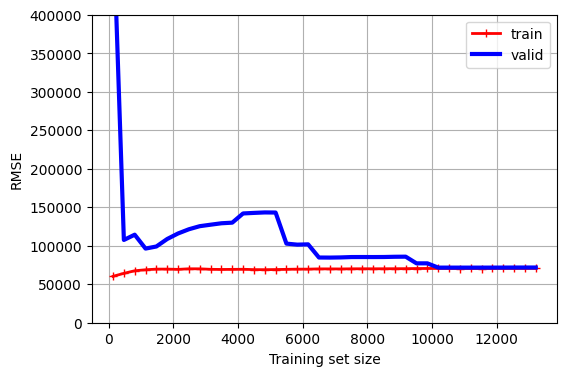

In [233]:


from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([None, None, 0, 400000])
plt.show()


The curves indicate the model is fitting well, since the performance on training set almost the same as the training set gets larger. The performance on the validation set improves with the size of training set. Both in-sample and out of sample performances reach a plateau with very small gap between them.

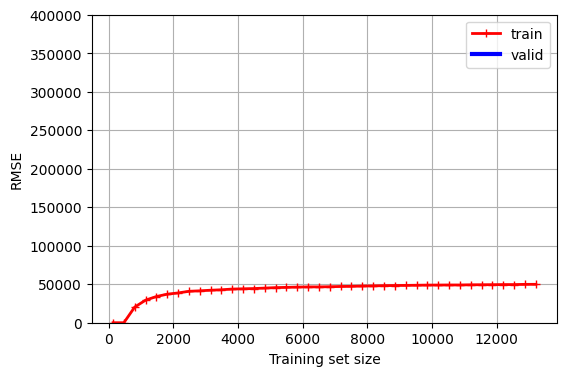

In [234]:
train_sizes, train_scores, valid_scores = learning_curve(
 lin_reg2, X_poly, y, train_sizes = np.linspace(0.01, 1.0, 40), cv = 5,
 scoring = "neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([None, None, 0, 400000])
plt.show()

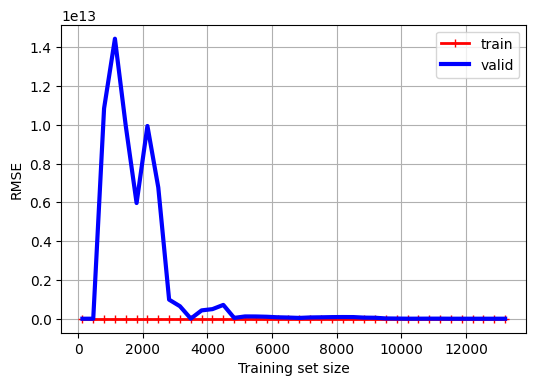

In [237]:
train_sizes, train_scores, valid_scores = learning_curve(
 lin_reg2, X_poly, y, train_sizes = np.linspace(0.01, 1.0, 40), cv = 5,
 scoring = "neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.show()

I set the rmse to be 0-400000 in the first plot in order to better compare with other models. This model also performe bad. The curves indicate the models are overfitting, since the performance on training set becomes worse as the training set gets larger. The performance on the validation set improves with the size of training set. Both in-sample and out of sample performances reach a plateau with a large gap between them.

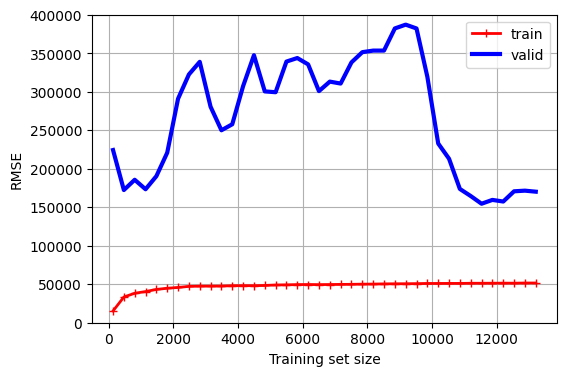

In [238]:
train_sizes, train_scores, valid_scores = learning_curve(
 ridge_reg, X_poly, y, train_sizes = np.linspace(0.01, 1.0, 40), cv=5,
 scoring = "neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([None, None, 0, 400000])
plt.show()

The curves indicate the models are overfitting, since the performance on training set becomes worse as the training set gets larger. The performance on the validation set improves with the size of training set. There is a large gap between in-sample and out of sample performances. But it is not important since the ridge performce bad.

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/104571273/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then use `sklearn.model_selection.train_test_split` to split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [239]:
import pandas as pd

df = pd.read_csv("Default.csv")


**Solution:**

In [240]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='default')
y = df['default'].replace({'Yes': 1, 'No': -1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

C:\Users\26386\AppData\Local\Temp\ipykernel_24616\1327291657.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['default'].replace({'Yes': 1, 'No': -1})


## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**Solution:**

In [241]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

# Create pipelines for numeric and categorical preprocessing
numeric_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder())

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, make_column_selector(dtype_include='float64')),
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object))
])

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test) 


## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC. Use the default arguments, except you must include the argument `random_state=42`.  Furthermore, for the logistic regression, compute the ROC AUC for `C` taking the values 0.001, 0.01, 0.1, 1, 10, 100, to show that the default value of 1 is approximately optimal.

**Solution:**

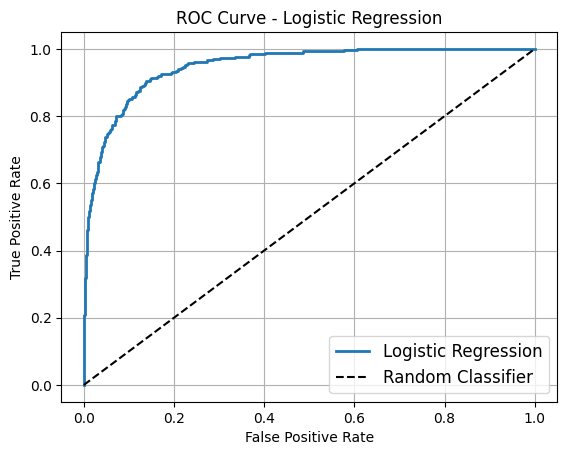

Logistic Regression ROC AUC: 0.950
C=0.001: ROC AUC =0.9466
C=0.01: ROC AUC =0.9500
C=0.1: ROC AUC =0.9503
C=1: ROC AUC =0.9501
C=10: ROC AUC =0.9502
C=100: ROC AUC =0.9502


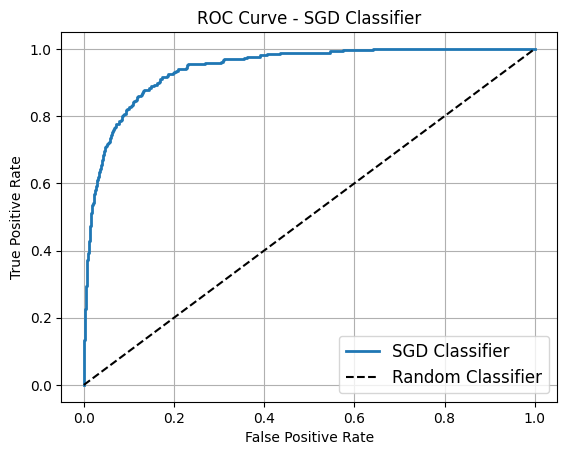

SGDClassifier ROC AUC: 0.943


In [242]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Logistic Regression with ROC curve
log_clf = LogisticRegression(random_state=42)
log_y_scores = cross_val_predict(log_clf, X_train, y_train, cv=10, method='decision_function')
log_fpr, log_tpr, log_thresholds = roc_curve(y_train, log_y_scores)

plt.plot(log_fpr, log_tpr, linewidth=2, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Logistic Regression")
plt.grid()
plt.legend(loc="lower right", fontsize=12)
plt.show()

# AUC Score
log_auc_score = roc_auc_score(y_train, log_y_scores)
print(f"Logistic Regression ROC AUC: {log_auc_score:.3f}")

# Evaluate ROC AUC for different values of C
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
roc_auc_scores_C = []

for C in C_values:
    log_clf_C = LogisticRegression(C=C, random_state=42)
    y_scores_C = cross_val_predict(log_clf_C, X_train, y_train, cv=10, method='decision_function')
    auc_score_C = roc_auc_score(y_train, y_scores_C)
    roc_auc_scores_C.append(auc_score_C)
    print(f"C={C}: ROC AUC ={auc_score_C:.4f}")

# SGD Classifier with ROC curve
sgd_clf = SGDClassifier(random_state=42)
sgd_y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=10, method='decision_function')
sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(y_train, sgd_y_scores)

plt.plot(sgd_fpr, sgd_tpr, linewidth=2, label="SGD Classifier")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - SGD Classifier")
plt.grid()
plt.legend(loc="lower right", fontsize=12)
plt.show()

# AUC Score for SGDClassifier
sgd_auc_score = roc_auc_score(y_train, sgd_y_scores)
print(f"SGDClassifier ROC AUC: {sgd_auc_score:.3f}")


## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 75%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve a 75% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**Solution:**

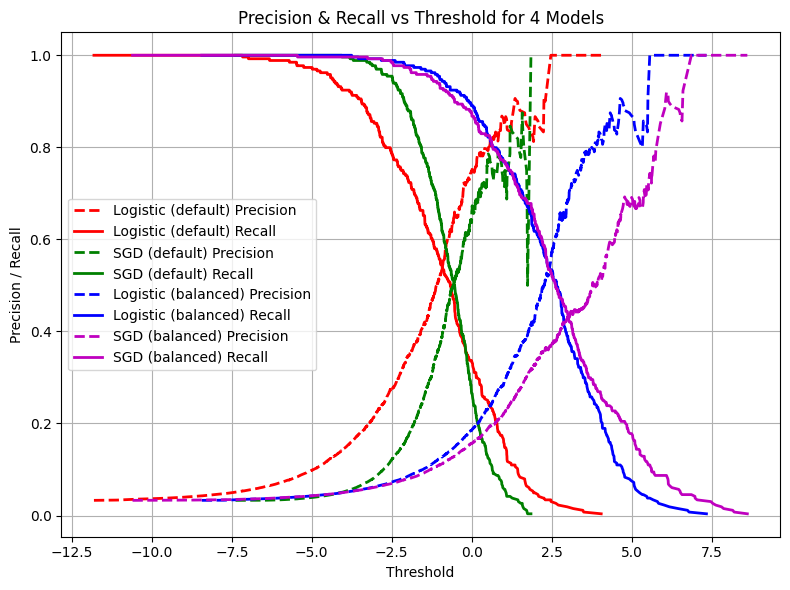


Thresholds and precision at 75% recall:

 Model=Logistic Regression (default)  | Threshold=-2.214 | Precision=0.311
 Model=SGDClassifier (default)        | Threshold=-1.350 | Precision=0.288
 Model=Logistic Regression (balanced) | Threshold=1.152 | Precision=0.309
 Model=SGDClassifier (balanced)       | Threshold=1.159 | Precision=0.238


In [243]:
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
import numpy as np
import matplotlib.pyplot as plt

# Set target recall level
target_recall = 0.75
models_prts = []

plt.figure(figsize=(8, 6))

# 1) Logistic Regression (default)
prec_log, rec_log, thr_log = precision_recall_curve(y_train, log_y_scores)
plt.plot(thr_log, prec_log[:-1], 'r--', label='Logistic (default) Precision', linewidth=2)
plt.plot(thr_log, rec_log[:-1], 'r-',  label='Logistic (default) Recall',    linewidth=2)
models_prts.append(('Logistic Regression (default)', prec_log, rec_log, thr_log))

# 2) SGDClassifier (default)
prec_sgd, rec_sgd, thr_sgd = precision_recall_curve(y_train, sgd_y_scores)
plt.plot(thr_sgd, prec_sgd[:-1], 'g--', label='SGD (default) Precision', linewidth=2)
plt.plot(thr_sgd, rec_sgd[:-1], 'g-',  label='SGD (default) Recall',    linewidth=2)
models_prts.append(('SGDClassifier (default)', prec_sgd, rec_sgd, thr_sgd))

# 3) Logistic Regression (balanced)
log_clf_bal = LogisticRegression(class_weight='balanced', random_state=42)
y_scores_log_bal = cross_val_predict(
    log_clf_bal, X_train, y_train, cv=10, method='decision_function'
)
prec_bal_log, rec_bal_log, thr_bal_log = precision_recall_curve(y_train, y_scores_log_bal)
plt.plot(thr_bal_log, prec_bal_log[:-1], 'b--', label='Logistic (balanced) Precision', linewidth=2)
plt.plot(thr_bal_log, rec_bal_log[:-1], 'b-',  label='Logistic (balanced) Recall',    linewidth=2)
models_prts.append(('Logistic Regression (balanced)', prec_bal_log, rec_bal_log, thr_bal_log))

# 4) SGDClassifier (balanced)
sgd_clf_bal = SGDClassifier(class_weight='balanced', random_state=42)
y_scores_sgd_bal = cross_val_predict(
    sgd_clf_bal, X_train, y_train, cv=10, method='decision_function'
)
prec_bal_sgd, rec_bal_sgd, thr_bal_sgd = precision_recall_curve(y_train, y_scores_sgd_bal)
plt.plot(thr_bal_sgd, prec_bal_sgd[:-1], 'm--', label='SGD (balanced) Precision', linewidth=2)
plt.plot(thr_bal_sgd, rec_bal_sgd[:-1], 'm-',  label='SGD (balanced) Recall',    linewidth=2)
models_prts.append(('SGDClassifier (balanced)', prec_bal_sgd, rec_bal_sgd, thr_bal_sgd))

# Final formatting
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision & Recall vs Threshold for 4 Models')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Now extract the thresholds and precisions at 75% recall:
print(f"\nThresholds and precision at {target_recall * 100:.0f}% recall:\n")
results = []
for model_name, prec, rec, thr in models_prts:
    idx = np.argmin(np.abs(rec - target_recall))
    threshold = thr[idx - 1] if 0 < idx < len(thr) else float('nan')
    precision_at_recall = prec[idx]
    results.append((model_name, threshold, precision_at_recall))

for name, thr, prec in results:
    print(f" Model={name:30s} | Threshold={thr:.3f} | Precision={prec:.3f}")


Based on my result, Logistic regression(default) has the best precision.

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**Solution:**

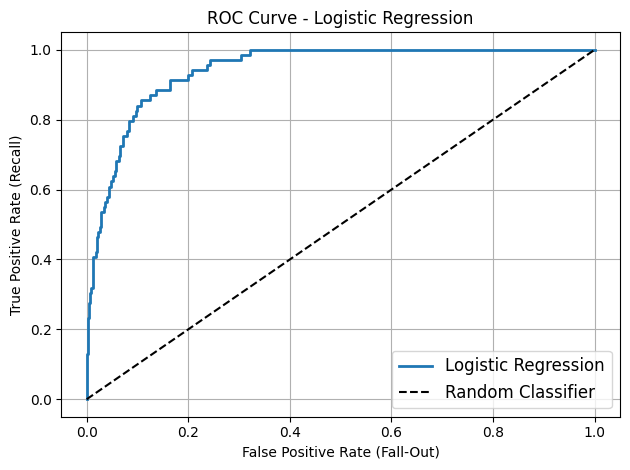

Accuracy: 0.9700
ROC AUC: 0.9435
Precision: 0.655
Recall:    0.275


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

# Train logistic regression model
log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train, y_train)

# Predict probabilities and scores
log_y_probas = log_clf.predict_proba(X_test)
log_y_scores = log_y_probas[:, 1]

# Accuracy score
accuracy = log_clf.score(X_test, y_test)

# Precision-recall curve
prec_log, rec_log, thr_log = precision_recall_curve(y_test, log_y_scores)

# ROC curve
fpr_log, tpr_log, roc_thr_log = roc_curve(y_test, log_y_scores)
plt.plot(fpr_log, tpr_log, linewidth=2, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

# AUC score
auc_log = roc_auc_score(y_test, log_y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {auc_log:.4f}")

from sklearn.metrics import precision_score, recall_score

y_pred = log_clf.predict(X_test)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")